In [1]:
!pip install PySastrawi
!pip install tensorflow

In [2]:
import pandas as pd
import urllib.request
import numpy as np
import os
import re
import seaborn as sns
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
from collections import Counter
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from scipy.stats import pearsonr
import matplotlib.pyplot as plt

# DATA PREPARATION

## Download the dataset
This dataset is comprised of mainly two parts; 46,119 raw article data, and 15,000 clickbait annotated sample headlines. Annotation was conducted with 3 annotator examining each headline. Judgment were based only on the headline. The majority then is considered as the ground truth. In the annotated sample, our annotation shows 6,290 clickbait and 8,710 non-clickbait.

|   	|   	|
|---	|---	|
|dataset article   	|https://www.data-in-brief.com/article/S2352-3409(20)31125-2/fulltext   	|
|kaggle   	|https://www.kaggle.com/datasets/andikawilliam/clickid   	|
|indonesia stopword |https://www.kaggle.com/datasets/oswinrh/indonesian-stoplist |


We would like to thank the publishers Detik, Fimela, Kapanlagi, Kompas, Liputan6, Republika, Sindonews, Tempo, Tribunnews, Okezone, Wowkeren, and Posmetro-Medan for providing their articles publicly available. This data would not be possible without the volunteers that have given their time and effort in labelling these headlines.

In [3]:
dataset_url = "https://raw.githubusercontent.com/gdapriana/news-clickbait/refs/heads/main/dataset/dataset.csv"
stopword_url = "https://raw.githubusercontent.com/gdapriana/news-clickbait/refs/heads/main/dataset/stopwordindonesia.csv"

if os.path.exists("dataset.csv") and os.path.exists("stopwordindonesia.csv"):
    print("Dataset already downloaded")
else:
    print("Downloading dataset...")
    urllib.request.urlretrieve(dataset_url, "dataset.csv")
    urllib.request.urlretrieve(stopword_url, "stopwordindonesia.csv")
    print("Done...")

Dataset already downloaded


## Data Selection

Only select 1k data from 17k data

In [4]:
dataset = pd.read_csv("dataset.csv", index_col=False).iloc[:1000]
dataset.info()
dataset.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   title        1000 non-null   object
 1   label        1000 non-null   object
 2   label_score  1000 non-null   int64 
dtypes: int64(1), object(2)
memory usage: 23.6+ KB


,title,label,label_score
0,"Masuk Radar Pilwalkot Medan, Menantu Jokowi Be...",non-clickbait,0
1,Malaysia Sudutkan RI: Isu Kabut Asap hingga In...,non-clickbait,0
2,Viral! Driver Ojol di Bekasi Antar Pesanan Mak...,clickbait,1
3,"Kemensos Salurkan Rp 7,3 M bagi Korban Kerusuh...",non-clickbait,0
4,"Terkait Mayat Bayi Mengenaskan di Tangerang, S...",non-clickbait,0


## Data Cleaning

remove unusend column & rename

In [5]:
dataset = dataset.drop(columns=["label"])
dataset = dataset.rename(columns={"label_score": "label"})

#check label is only 0 and 1
if dataset['label'].isin([0, 1]).all():
    print("label is only 0 and 1")
else:
    print("wrong label")

label is only 0 and 1


remove null and duplicates

In [6]:
dataset = dataset.drop_duplicates()
dataset = dataset.dropna()

change to lowercase, remove special character, remove number, whitespace

In [7]:
dataset['title'] = dataset['title'].str.lower()
dataset['title'] = dataset['title'].str.replace(r'[^a-zA-Z\s]', '', regex=True)
dataset['title'] = dataset['title'].str.replace(r'\d+', '', regex=True)
dataset['title'] = dataset['title'].str.strip()
dataset.head()

,title,label
0,masuk radar pilwalkot medan menantu jokowi ber...,0
1,malaysia sudutkan ri isu kabut asap hingga inv...,0
2,viral driver ojol di bekasi antar pesanan maka...,1
3,kemensos salurkan rp m bagi korban kerusuhan ...,0
4,terkait mayat bayi mengenaskan di tangerang se...,0


## Stemming With Sastrawi

| | |
|---|---|
|source| https://medium.com/@93Kryptonian/stemming-with-sastrawi-877cc40a37ad |

Sastrawi Python is a simple python library which allows you to reduce inflected words in Indonesian Language (Bahasa Indonesia) to their base form (stem). This is Python port of the original Sastrawi project written in PHP (credits goes to the original author and contributors of Sastrawi PHP).

In [8]:
Stemmer = StemmerFactory().create_stemmer()
dataset['title'] = dataset['title'].apply(lambda x: Stemmer.stem(x))
dataset.head()

,title,label
0,masuk radar pilwalkot medan menantu jokowi tem...,0
1,malaysia sudut ri isu kabut asap hingga invasi...,0
2,viral driver ojol di bekas antar pesan makan p...,1
3,kemensos salur rp m bagi korban rusuh sosial d...,0
4,kait mayat bayi enas di tangerang orang pria t...,0


## Stopword
https://www.opinosis-analytics.com/knowledge-base/stop-words-explained/

Stop words are a set of commonly used words in a language. Examples of stop words in English are “a,” “the,” “is,” “are,” etc. Stop words are commonly used in Text Mining and Natural Language Processing (NLP) to eliminate words that are so widely used that they carry very little useful information.

In [9]:
stopwords = pd.read_csv('stopwordindonesia.csv', header=None)
stopwords = stopwords[0].tolist()

def apply_stopwords(text):
  words = text.split()
  filtered_words = [word for word in words if word.lower() not in stopwords]
  return ' '.join(filtered_words)

dataset['title'] = dataset['title'].apply(apply_stopwords)
dataset.head()


,title,label
0,masuk radar pilwalkot medan menantu jokowi tem...,0
1,malaysia sudut ri isu kabut asap invasi babi,0
2,viral driver ojol bekas pesan makan pakai sepeda,1
3,kemensos salur rp m korban rusuh sosial papua,0
4,kait mayat bayi enas tangerang orang pria tang...,0


## TF-IDF

https://medium.com/data-folks-indonesia/bag-of-words-vs-tf-idf-penjelasan-dan-perbedaannya-3739f32cdc72

https://youtu.be/f0a1XXmaQp8?si=YryiX4rMkcDPVc-I

TF-IDF stands for Term Frequency - Inverse Document Frequency. In fact, TF-IDF is a combination of 2 processes, namely Term Frequency (TF) and Inverse Document Frequency (IDF).

TF-IDF is commonly used when we want to convert text data into vectors but with attention to whether a word is informative enough or not. Simply put, TF-IDF makes words that appear frequently have values that tend to be small, while words that appear less frequently will have values that tend to be large. Frequently occurring words also called Stopwords are usually considered less important, one example is conjunctions (which, in, will, with, etc.).

In [10]:
vectorizer = TfidfVectorizer()
response = vectorizer.fit_transform(dataset['title'])

In [11]:
X = response.toarray()
y = dataset['label'].to_numpy()

## Normalization

https://c3.ai/glossary/data-science/normalization/

Normalization is a data transformation process that aligns data values to a common scale or distribution of values so that. Normalization includes adjusting the scale of values to a similar metric or adjusting the time scales to be able to compare like periods. For example, if you have health data with annual height measurements in feet and daily weight measurements in pounds, normalizing the data could be adjusting the values to the percentage of the range between the minimum and maximum values.

In [12]:
scaler = MinMaxScaler(feature_range=(0, 1))
X = scaler.fit_transform(X)

## Outliers Detections

https://www.freecodecamp.org/news/what-is-an-outlier-definition-and-how-to-find-outliers-in-statistics/

In simple terms, an outlier is an extremely high or extremely low data point relative to the nearest data point and the rest of the neighboring co-existing values in a data graph or dataset you're working with.



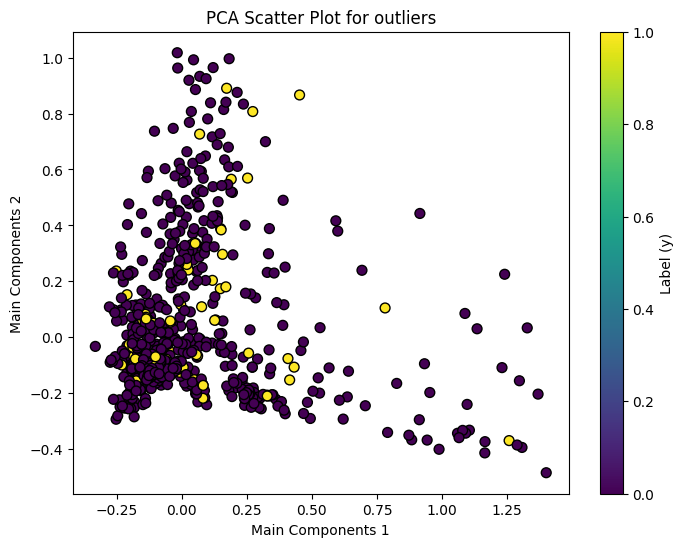

In [13]:
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

plt.figure(figsize=(8, 6))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y, cmap='viridis', edgecolor='k', s=50)
plt.title("PCA Scatter Plot for outliers")
plt.xlabel("Main Components 1")
plt.ylabel("Main Components 2")
plt.colorbar(label="Label (y)")
plt.show()

## Correlation

https://www.bmj.com/about-bmj/resources-readers/publications/statistics-square-one/11-correlation-and-regression

Data correlation is a method for measuring the relationship between variables in a dataset, which helps understand whether a change in one variable is followed by a change in another. Correlation is important in data analysis as it can help identify patterns and select relevant features for machine learning models.


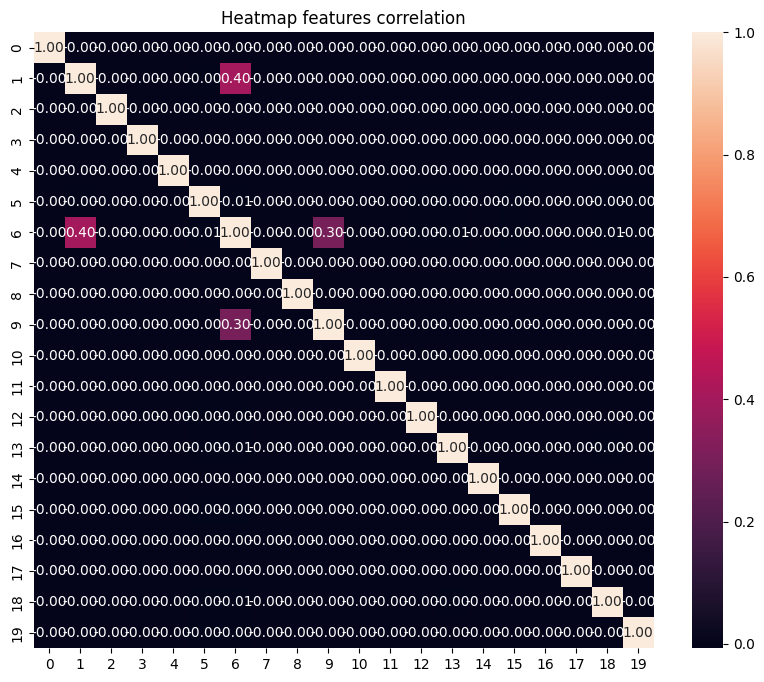

In [14]:
correlation_matrix = np.corrcoef(X, rowvar=False)
correlations = [pearsonr(X[:, i], y)[0] for i in range(X.shape[1])]

subset_corr = correlation_matrix[:20, :20]

plt.figure(figsize=(10, 8))
sns.heatmap(subset_corr, annot=True, fmt=".2f")
plt.title("Heatmap features correlation")
plt.show()

## Data Splitting

https://medium.com/@datasciencewizards/a-guide-to-data-splitting-in-machine-learning-49a959c95fa1

In data science or machine learning, data splitting comes into the picture when the given data is divided into two or more subsets so that a model can get trained, tested and evaluated.

in this case, 80% train and 20% test

In [19]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# MODEL (USING TENSORFLOW)

In [21]:
import tensorflow as tf
from sklearn.metrics import accuracy_score

In [24]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(64, activation='relu', input_shape=(X.shape[-1],)),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [25]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [26]:
history = model.fit(X_train, y_train, epochs=20, batch_size=32, validation_split=0.2)

Epoch 1/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - accuracy: 0.8545 - loss: 0.6408 - val_accuracy: 0.8625 - val_loss: 0.5451
Epoch 2/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9050 - loss: 0.4436 - val_accuracy: 0.8625 - val_loss: 0.4197
Epoch 3/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8951 - loss: 0.2789 - val_accuracy: 0.8625 - val_loss: 0.4225
Epoch 4/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9099 - loss: 0.1873 - val_accuracy: 0.8625 - val_loss: 0.4432
Epoch 5/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9012 - loss: 0.1475 - val_accuracy: 0.8625 - val_loss: 0.4563
Epoch 6/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9017 - loss: 0.1230 - val_accuracy: 0.8625 - val_loss: 0.4776
Epoch 7/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9116 - loss: 0.1111 - val_accuracy: 0.8562 - val_loss: 0.5138
Epoch 8/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9705 - loss: 0.0791 - val_accuracy: 0.8562 - val_loss

In [28]:
model.evaluate(X_test, y_test)

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8721 - loss: 0.5821  


[0.5843002200126648, 0.875]

# MODEL (Using SVM)

In [30]:
from sklearn import svm
clf = svm.SVC()
clf.fit(X_train, y_train)

SVC()

In [31]:
classifier = clf.predict(X_test)
print(accuracy_score(y_test, classifier)*100)

88.0
